In [21]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shadow_evolution_learning.utils.operations import pX,pZ,pY
from shadow_evolution_learning.shadow_sampling.shadow_loader import data_loader
from shadow_evolution_learning.train import extract_params
from shadow_evolution_learning.utils.network_utils import construct_exact_vals

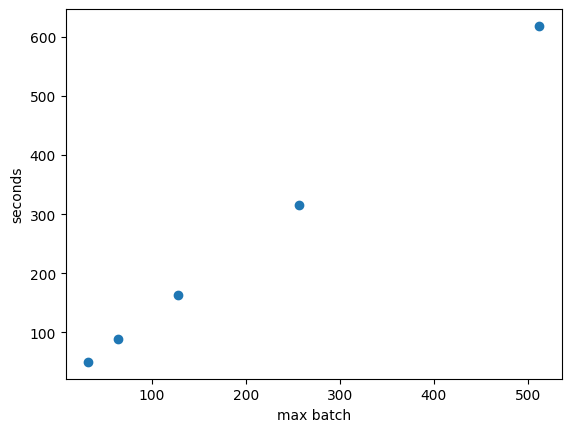

In [13]:
max_b = [32,64,128,256,512]
seconds = [50.146,88.445,164.078,316.08312368392944,618.539]
plt.scatter(max_b,seconds)
plt.xlabel('max batch')
plt.ylabel('seconds')
plt.show()

In [14]:
path = '/users/csmith36/shadows/NNSHL/ising/results/periodic_actvfn/measurements=10000_k=10/start=0.5_dt=0.1_steps=10/index=2/max_hid=20_min_hid=5/lr=0.01'
#print(path[:path.find('/index=')])
path_update = path[:path.find('/index=')] + '/index=' + str(0)

In [15]:
obs_0 = [-jnp.kron(pZ,jnp.eye(2)),jnp.kron(pY,pX)]
obs_1 = [jnp.kron(jnp.eye(2),pX),jnp.kron(jnp.eye(2),pY)]
obs_2 = [jnp.kron(pX,jnp.eye(2)),jnp.kron(pY,jnp.eye(2))]
p_0 = jnp.kron(obs_0[0],obs_0[1])
p_1 = jnp.kron(obs_1[0],obs_1[1])
p_2 = jnp.kron(obs_2[0],obs_2[1])

q_0 = jnp.kron(obs_0[1],obs_0[1])
q_1 = jnp.kron(obs_1[1],obs_1[1])
q_2 = jnp.kron(obs_2[1],obs_2[1])

full_obs = [[p_0,q_0],[p_1,q_1],[p_2,q_2]]

In [22]:
p_0_s = np.array([2,1,0]), np.array([0,2,3])
p_1_s = np.array([0,1]), np.array([1,3])
p_2_s = np.array([0,1]), np.array([0,2])

q_0_s = np.array([1,0,1,0]), np.array([0,1,2,3])
q_1_s = np.array([1,1]), np.array([1,3])
q_2_s = np.array([1,1]), np.array([0,2])

full_shadow_obs = [[p_0_s,q_0_s],[p_1_s,q_1_s],[p_2_s,q_2_s]]

In [64]:
start = 0.5
steps = 80
dt = 0.01
train_times = np.array([round(start + i*dt,4) for i in range(steps)])
meas = 10000
plot = False

In [82]:
vals = np.load('/users/csmith36/shadows/NNSHL/ising/ising_shadow_data/params.npy',allow_pickle=True)

def load_training_results(path):
    full_val_loss = []
    full_coeffs = []
    full_mindices = []
    full_preds = []
    shadow_means = []
    pred_means = []
    for val_ind in range(10):
        mindices = []
        mindices_ind = []
        val_losses = []
        val_coeffs = []
        preds = []
        minimums = []
        val = vals[val_ind]
        pXX = jnp.kron(pX,pX)
        hamil = val[0]*pXX + val[1]*jnp.kron(pZ,jnp.eye(2)) + val[2]*jnp.kron(jnp.eye(2),pZ)
        test_times = np.load('/users/csmith36/shadows/NNSHL/ising/results/periodic_actvfn/measurements=10000_k=10/start=0.5_dt=0.1_steps=10/index=0/max_hid=20_min_hid=5/lr=0.01/seed=0/test_times.npy',allow_pickle=True)
        true_obs = construct_exact_vals(test_times,hamil,full_obs)
        shadow_obs_p_ts, shadow_obs_q_ts = data_loader(train_times,meas,val_ind,full_shadow_obs,k=10)
        #print(shadow_obs_p_ts.shape)
        colors = ['teal','forestgreen','navy','magenta','skyblue','orange']
        full = np.concatenate([shadow_obs_p_ts,shadow_obs_q_ts],axis=-1)
        true_obs_comp = construct_exact_vals(train_times,hamil,full_obs).reshape((80,6))
        shadow_means.append(jnp.mean(jnp.abs(full-true_obs_comp)))
        if plot:
            for w in range(6):
                plt.plot(train_times,full[:,w],color=colors[w],linestyle='dotted')
            #for w in range(3):
            #    plt.scatter(train_times,shadow_obs_p_ts[:,w],color=colors[2*w])
            #    plt.scatter(train_times,shadow_obs_q_ts[:,w],color=colors[2*w+1])
            for w in range(6):
                if w%2 == 0:
                    plt.plot(test_times,true_obs.reshape(-1,6)[:,w],label='p'+str(w//2), color = colors[w])
                else:
                    plt.plot(test_times,true_obs.reshape(-1,6)[:,w],label='q'+str(w//2),color = colors[w])
        #plt.show()
        for seed in range(10):
            path2 = path[:path.find('/index=')] + '/index=' + str(val_ind) + path[path.find('/max_'):] + '/seed='+str(seed)
            test_times = np.load(path2+'/test_times.npy',allow_pickle=True)
            coeff = np.load(path2+'/coeff_predicts.npy',allow_pickle=True)
            val_loss = np.load(path2 + '/val_losses.npy',allow_pickle=True)
            full_pred = np.load(path2+'/full_predicts.npy')
            preds.append(full_pred)

            index = np.argmin(np.mean(np.mean(val_loss,axis=1),axis=-1))
            mean_ind = np.mean(val_loss,axis=-2)
            min_val_loss_ind = np.argmin(mean_ind,axis=0)
            mindices_ind.append(min_val_loss_ind)
            mindices.append(index)
            val_losses.append(np.min(np.mean(np.mean(val_loss,axis=1),axis=-1)))
            coeff_updated = coeff[index]
            #print(extract_params(full_pred[index],test_times[-2]-test_times[-3],len(test_times))-coeff_updated)
            val_coeffs.append(np.median(coeff_updated/2,axis=-2)[np.array([0,2,1])])
            minimums.append(np.min(np.sum(np.abs(coeff[:,:,np.array([0,2,1])]/2 - vals[val_ind]),axis=(2))))
        full_val_loss.append(val_losses)
        full_coeffs.append(val_coeffs)
        full_mindices.append(mindices)
        full_preds.append(preds)
        
        #print(np.array(mindices_ind[0]).shape)
        #print(np.array(preds).shape)
        #print(np.array(preds)[0].shape)
        tmp = np.array([np.array(preds)[0,np.array(mindices_ind)[0,w],:,w] for w in range(6)])
        #print(tmp.shape)
        if plot:
            for w in range(6):
                if w%2 == 0:
                    plt.plot(test_times,np.array(preds)[0,np.array(mindices_ind)[0,w],:,w], '--',label='p'+str(w//2),color = colors[w])
                else:
                    plt.plot(test_times,np.array(preds)[0,np.array(mindices_ind)[0,w],:,w], '--',label='q'+str(w//2),color = colors[w])
            line_s = Line2D([0,1],[0,1],linestyle='-', color='black')
            line_dash = Line2D([0,1],[0,1],linestyle='--', color='black')
            line_dotted = Line2D([0,1],[0,1],linestyle='dotted', color='black')
            plt.legend([line_s,line_dash,line_dotted],['True Value','Predicted Value','Shadow Value'])
            plt.show()
        pred_means.append(jnp.mean(jnp.array([jnp.abs(np.array(preds)[0,np.array(mindices_ind)[0,w],:,w] - true_obs.reshape(-1,6)[:,w]) for w in range(6)] )))
    full_coeffs = np.array(full_coeffs)
    full_val_loss = np.array(full_val_loss)
    full_mindices = np.array(full_mindices)
    index2 = np.argmin(full_val_loss,axis=-2)
    min_errs = np.mean(np.abs(full_coeffs.transpose(1,0,2)[index2,np.array([i for i in range(10)])]-vals[:10]))

    

    meds = np.median(full_coeffs,axis=-2)

    print(full_coeffs.shape)
    print('errors:',jnp.mean(np.array(shadow_means)),jnp.mean(np.array(pred_means)))
    print('mean of medians',np.mean(np.abs(meds-vals[:10]),axis=-1))
    print('median of medians',np.mean(np.abs(meds-vals[:10])))
    print(np.mean(np.abs(meds-vals[:10])))
    print('min_val_loss',min_errs)
    return full_val_loss, full_coeffs, full_mindices
full_val_loss, full_coeffs, full_mindices = load_training_results(path)


(10, 10, 3)
errors: 0.030451238 0.027588716
mean of medians 0.08029436809768802
median of medians 0.047994404311004435
0.08029436809768802
min_val_loss 0.089125206644737


In [78]:
print(full_coeffs.shape)

print(np.mean(np.abs(full_coeffs.transpose(1,0,2)-vals)))

(10, 10, 3)
0.0965847425036982
